In [1]:
!pip install --force-reinstall git+https://github.com/yhhc2/IsoRanker.git

  Cloning https://github.com/yhhc2/IsoRanker.git to /tmp/pip-req-build-8vtmmfos
  Running command git clone --filter=blob:none --quiet https://github.com/yhhc2/IsoRanker.git /tmp/pip-req-build-8vtmmfos
  Resolved https://github.com/yhhc2/IsoRanker.git to commit fdc981ac44e45bc21e9ae4e4c33f25a79b056435
  Preparing metadata (setup.py) ... done
  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pyreadr-0.5.3-cp312-cp312-manylinux_2_17_x86_

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns


In [3]:
# Import functions from the package
from IsoRanker import (
    load_data,
    filter_based_on_counts,
    apply_hypothesis_test,
    calculate_z_score,
    NMD_test_statistic,
    Noncyclo_Expression_Outlier_LOE,
    Noncyclo_Expression_Outlier_GOE,
    Cyclo_Expression_Outlier_GOE,
    NMD_rare_steady_state_transcript,
    Noncyclo_Allelic_Imbalance,
    Cyclo_Allelic_Imbalance,
    calculate_ranks_for_sample,
    create_expression_matrix,
    create_long_format,
    process_hypothesis_test,
    update_files_with_haplotype_info,
    merge_csvs_by_keyword, 
    process_vep_vcf, 
    merge_haplotype_data, 
    process_phenotype_data,
    process_and_plot_pca,
    analyze_isoforms,
    process_pileup
)


### Assign input paths

In [4]:
# EXAMPLE
# Provides every single read, which sample each read came from, and the isoform asssociated with each read
read_stat_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression/Input/read_stats.txt"

# Assigns samples to patients, cyclo/non-cyclo
sample_info_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression/Input/Sample_info.csv"
sample_info = pd.read_csv(sample_info_path)

# Provides pigeon annotation for isoforms
classification_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression/Input/filtered_classification.txt"
classification_data = pd.read_csv(classification_path, sep="\t")

# Provide omim information for genes
genemap_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker_testing/genemap2.txt"
genemap = pd.read_csv(genemap_path, sep='\t', skiprows=3) # Read the file, skipping the first 3 rows
genemap = genemap[genemap['Approved Gene Symbol'].notnull()]


### Create isoform expression matrix and convert it to long format, then add gene information to enable gene-level analysis

#### Option 1: If creating expression matrix from PacBio Isoseq pipeline, please uncomment and specify path of read_stat file:

In [5]:
## Option 1:

# Create the expression matrix and save it to a file
expression_matrix = create_expression_matrix(read_stat_path, output_file="expression_matrix.csv.gz")


#### Option 2: If using expression matrix directly, please uncomment and specify location of expression matrix
- Please see Output/intermediate/expression_matrix.csv.gz for an example of how to format expression matrix.
- Please see Output/intermediate/updated_sample_info.csv.gz for an example of how to format sample info.

In [6]:
## Option 2:

# expression_matrix = pd.read_csv("expression_matrix.csv.gz", compression = "gzip", index_col=0)
# sample_info = pd.read_csv("updated_sample_info.csv.gz", compression = "gzip")


In [7]:
# Generate the long-format dataFrame and adding cyclo/noncyclo as well as haplotype labels and calculate TPM
long_format_df = create_long_format(expression_matrix, sample_info)


/mmfs1/gscratch/stergachislab/yhhc/tools/miniconda3/miniconda3/envs/jupyter-notebook/lib/python3.12/site-packages/IsoRanker/expression_matrix.py:170: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if sample_info['haplotype'].replace(['', 'none', "H0"], float('NaN'), inplace=False).isna().all():


In [8]:
# Select only the 'isoform' and 'associated_gene' columns from classification_data
classification_subset = classification_data[['isoform', 'associated_gene']]
# Merge the classification subset with the long_format_df
long_format_annotated = long_format_df.merge(
    classification_subset,
    left_on="Isoform",   # Match isoform IDs in long_format_df
    right_on="isoform",  # Match isoform IDs in classification_subset
    how="left"           # Keep all rows from long_format_df, even if there's no match in classification_subset
).drop(columns=["isoform"])  # Drop redundant 'isoform' column from classification_subset

long_format_annotated.to_csv("long_format_annotated.csv.gz", index=False, compression = "gzip")


### Calculate test stat and rankings

In [9]:
# Calculate for all hypothesis tests
test_stat_funcs = [
    ("Noncyclo_LOE", Noncyclo_Expression_Outlier_LOE),
    ("Noncyclo_GOE", Noncyclo_Expression_Outlier_GOE)
]

# Store full results to generate lookup table
full_ranked_gene_data = []

#Gene level
for test_name, test_func in test_stat_funcs:
        print(f"Processing test statistic: {test_name}")

        # Apply the process_hypothesis_test function
        ranked_data = process_hypothesis_test(
            filtered_data=long_format_annotated, 
            group_col='Isoform', 
            test_statistic_func=test_func, 
            gene_group_col='associated_gene', 
            gene_level=True, 
            bin_proportion=0.01, 
            filter_before_ranking=True, 
            filter_count_threshold=10)

        # Append tuple (test_name, ranked_data) to the list
        full_ranked_gene_data.append((test_name, ranked_data))

        filtered_ranked_data = ranked_data[ranked_data["rank_top_99_5_percentile"] <= 25]

        # Add OMIM data to genes
        filtered_ranked_data = filtered_ranked_data.merge(
            genemap[['Approved Gene Symbol', 'Phenotypes']],  # Select relevant columns from genemap
            how='left',  # Perform a left join to keep all rows from filtered_ranked_data
            left_on='associated_gene',  # Column in filtered_ranked_data to join on
            right_on='Approved Gene Symbol'  # Column in genemap to join on
        )
        # Drop the 'Approved Gene Name' column if it is no longer needed
        filtered_ranked_data = filtered_ranked_data.drop(columns=['Approved Gene Symbol'])

        # Save the results to a CSV file
        output_dir = ""
        output_file = os.path.join(output_dir, f"{test_name}_gene_top_ranked_data.csv.gz")
        filtered_ranked_data.to_csv(output_file, index=False, compression = "gzip")
        print(f"Results saved to {output_file}")


Processing test statistic: Noncyclo_LOE
Results saved to Noncyclo_LOE_gene_top_ranked_data.csv.gz
Processing test statistic: Noncyclo_GOE
Results saved to Noncyclo_GOE_gene_top_ranked_data.csv.gz


In [10]:
test_stat_funcs = [
    ("Noncyclo_LOE", Noncyclo_Expression_Outlier_LOE),
    ("Noncyclo_GOE", Noncyclo_Expression_Outlier_GOE)
]

#Isoform level
for test_name, test_func in test_stat_funcs:
        print(f"Processing test statistic: {test_name}")

        # Apply the process_hypothesis_test function
        ranked_data = process_hypothesis_test(
            filtered_data=long_format_annotated, 
            group_col='Isoform', 
            test_statistic_func=test_func, 
            gene_group_col='associated_gene', 
            gene_level=False, 
            bin_proportion=0.01, 
            filter_before_ranking=True, 
            filter_count_threshold=10)

        filtered_ranked_data = ranked_data[ranked_data["rank_top_99_5_percentile"] <= 25]

        # Add OMIM data to genes
        filtered_ranked_data = filtered_ranked_data.merge(
            genemap[['Approved Gene Symbol', 'Phenotypes']],  # Select relevant columns from genemap
            how='left',  # Perform a left join to keep all rows from filtered_ranked_data
            left_on='associated_gene',  # Column in filtered_ranked_data to join on
            right_on='Approved Gene Symbol'  # Column in genemap to join on
        )
        # Drop the 'Approved Gene Name' column if it is no longer needed
        filtered_ranked_data = filtered_ranked_data.drop(columns=['Approved Gene Symbol'])

        # Save the results to a CSV file
        output_dir = ""
        output_file = os.path.join(output_dir, f"{test_name}_isoform_top_ranked_data.csv.gz")
        filtered_ranked_data.to_csv(output_file, index=False, compression = "gzip")
        print(f"Results saved to {output_file}")

Processing test statistic: Noncyclo_LOE
Results saved to Noncyclo_LOE_isoform_top_ranked_data.csv.gz
Processing test statistic: Noncyclo_GOE
Results saved to Noncyclo_GOE_isoform_top_ranked_data.csv.gz


### Combine all output files

In [11]:
# Isoform
directory = "."
keyword = "isoform" 
output_csv = os.path.join(directory, f"merged_ranked_{keyword}.csv.gz")
merge_csvs_by_keyword(directory, keyword, output_csv)

# Gene
directory = "."
keyword = "gene"
output_csv = os.path.join(directory, f"merged_ranked_{keyword}.csv.gz")
merge_csvs_by_keyword(directory, keyword, output_csv)


Merged 2 'isoform' files into: ./merged_ranked_isoform.csv.gz
Merged 2 'gene' files into: ./merged_ranked_gene.csv.gz


### Lookup tables

In [12]:
# Collapse long_format_annotated by summing TPM values per Sample and Gene
sample_gene_rankings_lookup_table = long_format_annotated.groupby(["Sample", "associated_gene"], as_index=False).agg(
    {"Cyclo_TPM": "sum", "Noncyclo_TPM": "sum"}
)

# Now merge the ranked gene-level data
for test_name, df in full_ranked_gene_data:
    # Rename rank column to be test-specific
    df_renamed = df.rename(columns={"rank_top_99_5_percentile": f"{test_name}_rank_top_99_5_percentile"})

    # Keep only relevant columns
    df_renamed = df_renamed[["Sample", "associated_gene", f"{test_name}_rank_top_99_5_percentile"]]

    # Merge into merged_df using outer join
    sample_gene_rankings_lookup_table = pd.merge(sample_gene_rankings_lookup_table, df_renamed, on=["Sample", "associated_gene"], how="outer")

# Save as a compressed CSV (gzip format)
sample_gene_rankings_lookup_table.to_csv("sample_gene_rankings_lookup_table.csv.gz", index=False, compression="gzip")

# Group by gene (associated_gene) and compute median, Q1 (25th percentile), and Q3 (75th percentile)
gene_coverage_lookup_table = sample_gene_rankings_lookup_table.groupby("associated_gene").agg(
    Cyclo_TPM_median=("Cyclo_TPM", "median"),
    Cyclo_TPM_Q1=("Cyclo_TPM", lambda x: x.quantile(0.25)),  # 25th percentile
    Cyclo_TPM_Q3=("Cyclo_TPM", lambda x: x.quantile(0.75)),  # 75th percentile
    Cyclo_TPM_min=("Cyclo_TPM", "min"),  # Minimum value
    Cyclo_TPM_max=("Cyclo_TPM", "max"),  # Maximum value

    Noncyclo_TPM_median=("Noncyclo_TPM", "median"),
    Noncyclo_TPM_Q1=("Noncyclo_TPM", lambda x: x.quantile(0.25)),  # 25th percentile
    Noncyclo_TPM_Q3=("Noncyclo_TPM", lambda x: x.quantile(0.75)),  # 75th percentile
    Noncyclo_TPM_min=("Noncyclo_TPM", "min"),  # Minimum value
    Noncyclo_TPM_max=("Noncyclo_TPM", "max")   # Maximum value
).reset_index()

gene_coverage_lookup_table.to_csv("gene_coverage_lookup_table.csv.gz", index=False, compression="gzip")



### QC

In [13]:
###################################
# PCA
###################################

pca_results = process_and_plot_pca(long_format_annotated, output_pdf="pca_plot.pdf", grouping_col = "associated_gene")

In [14]:
###################################
# Gene diversity
###################################

analyze_isoforms(long_format_annotated, "gene_diversity.csv.gz", "associated_gene")

###################################
# Isoform diversity
###################################

analyze_isoforms(long_format_annotated, "isoform_diversity.csv.gz", "Isoform")



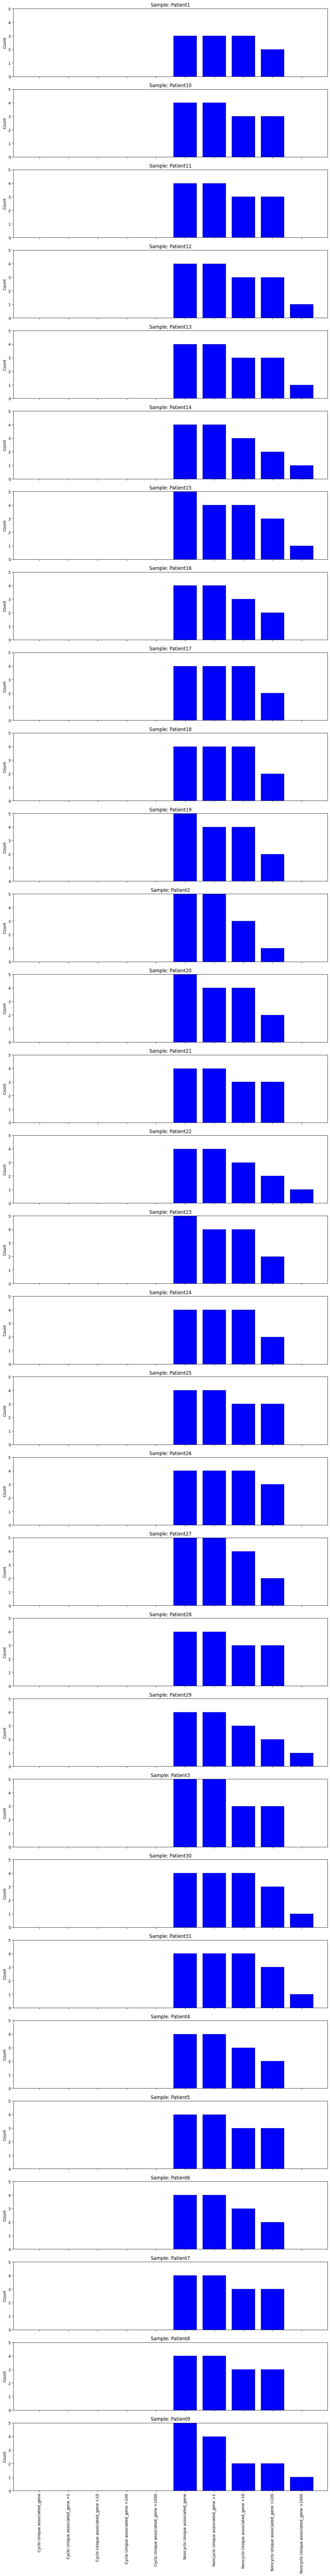

In [15]:
###################################
# Gene diversity plot
###################################

df = pd.read_csv("gene_diversity.csv.gz", compression = "gzip")

# Drop 'Cyclo Total Reads' and 'Noncyclo Total Reads' columns
df_filtered = df.drop(columns=["Cyclo Total Reads", "Noncyclo Total Reads"])

# Define colors for Cyclo and Noncyclo categories
cyclo_color = "red"
noncyclo_color = "blue"

# Determine a common y-axis limit for all plots
y_max = df_filtered.drop(columns=["Sample"]).max().max()

# Create subplots for each sample
num_samples = len(df_filtered["Sample"])
fig, axes = plt.subplots(nrows=num_samples, figsize=(12, num_samples * 3), sharex=True, sharey=True)

# If only one sample, make axes iterable
if num_samples == 1:
    axes = [axes]

# Loop through each sample and create a separate bar plot
for ax, sample in zip(axes, df_filtered["Sample"]):
    sample_data = df_filtered[df_filtered["Sample"] == sample].drop(columns=["Sample"]).T
    colors = [cyclo_color if "Cyclo" in col else noncyclo_color for col in sample_data.index]
    
    ax.bar(sample_data.index, sample_data.iloc[:, 0], color=colors)
    ax.set_title(f"Sample: {sample}")
    ax.set_ylabel("Count")
    ax.set_ylim(0, y_max)  # Set common y-axis limit
    ax.tick_params(axis="x", rotation=90)

# Formatting
plt.tight_layout()

# Save to PDF
plt.savefig("gene_diversity.pdf", format="pdf")


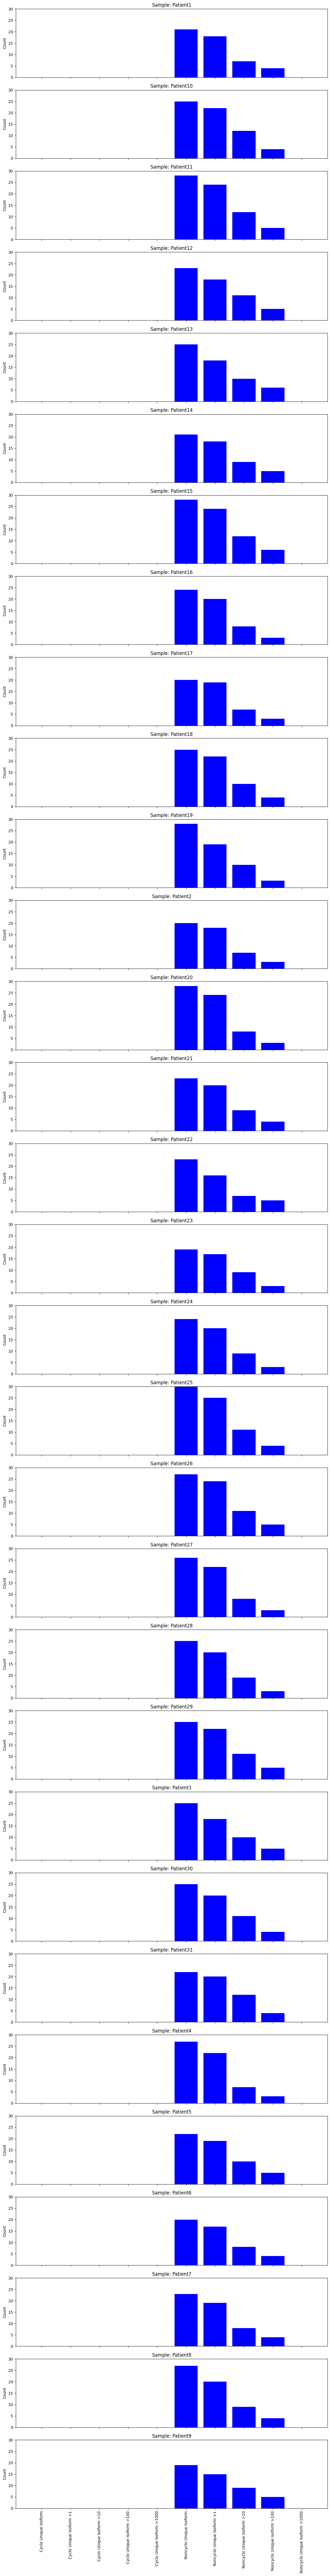

In [16]:
###################################
# Isoform diversity plot
###################################

df = pd.read_csv("isoform_diversity.csv.gz", compression = "gzip")

# Drop 'Cyclo Total Reads' and 'Noncyclo Total Reads' columns
df_filtered = df.drop(columns=["Cyclo Total Reads", "Noncyclo Total Reads"])

# Define colors for Cyclo and Noncyclo categories
cyclo_color = "red"
noncyclo_color = "blue"

# Determine a common y-axis limit for all plots
y_max = df_filtered.drop(columns=["Sample"]).max().max()

# Create subplots for each sample
num_samples = len(df_filtered["Sample"])
fig, axes = plt.subplots(nrows=num_samples, figsize=(12, num_samples * 3), sharex=True, sharey=True)

# If only one sample, make axes iterable
if num_samples == 1:
    axes = [axes]

# Loop through each sample and create a separate bar plot
for ax, sample in zip(axes, df_filtered["Sample"]):
    sample_data = df_filtered[df_filtered["Sample"] == sample].drop(columns=["Sample"]).T
    colors = [cyclo_color if "Cyclo" in col else noncyclo_color for col in sample_data.index]
    
    ax.bar(sample_data.index, sample_data.iloc[:, 0], color=colors)
    ax.set_title(f"Sample: {sample}")
    ax.set_ylabel("Count")
    ax.set_ylim(0, y_max)  # Set common y-axis limit
    ax.tick_params(axis="x", rotation=90)

# Formatting
plt.tight_layout()

# Save to PDF
plt.savefig("isoform_diversity.pdf", format="pdf")


### Organizing output files

In [17]:
import os
import shutil

# Define folder names
OUTPUT_FOLDER = "Output"
QC_FOLDER = os.path.join(OUTPUT_FOLDER, "qc")
BROWSER_FOLDER = os.path.join(OUTPUT_FOLDER, "browser")
LOOKUP_TABLES_FOLDER = os.path.join(BROWSER_FOLDER, "lookup_tables")
COMBINED_RESULTS_FOLDER = os.path.join(BROWSER_FOLDER, "combined_results")
SEPARATED_RESULTS_FOLDER = os.path.join(BROWSER_FOLDER, "separated_results")
INTERMEDIATE_FOLDER = os.path.join(OUTPUT_FOLDER, "intermediate")

# Ensure directories exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(QC_FOLDER, exist_ok=True)
os.makedirs(BROWSER_FOLDER, exist_ok=True)
os.makedirs(LOOKUP_TABLES_FOLDER, exist_ok=True)
os.makedirs(COMBINED_RESULTS_FOLDER, exist_ok=True)
os.makedirs(SEPARATED_RESULTS_FOLDER, exist_ok=True)
os.makedirs(INTERMEDIATE_FOLDER, exist_ok=True)

# Define file categories
qc_files = {
    "pca_plot.pdf",
    "gene_diversity.csv.gz",
    "isoform_diversity.csv.gz",
    "SRSF6.csv.gz",
    "SRSF6_exonic_proportion.pdf",
    "isoform_diversity.pdf",
    "gene_diversity.pdf"
}

lookup_table_files = {
    "sample_gene_rankings_lookup_table.csv.gz",
    "gene_coverage_lookup_table.csv.gz"
}

combined_results_files = {
    "merged_ranked_gene_with_phenotype.csv.gz",
    "merged_ranked_isoform_with_phenotype.csv.gz",
    "merged_ranked_isoform.csv.gz",
    "merged_ranked_gene.csv.gz"
}

separated_results_files = {
    "Cyclo_Allelic_Imbalance_gene_top_ranked_data.csv.gz",
    "Cyclo_GOE_gene_top_ranked_data.csv.gz",
    "Cyclo_GOE_isoform_top_ranked_data.csv.gz",
    "NMD_gene_top_ranked_data.csv.gz",
    "NMD_isoform_top_ranked_data.csv.gz",
    "NMD_rare_steady_state_transcript_gene_top_ranked_data.csv.gz",
    "Noncyclo_GOE_gene_top_ranked_data.csv.gz",
    "Noncyclo_GOE_isoform_top_ranked_data.csv.gz",
    "Noncyclo_LOE_gene_top_ranked_data.csv.gz",
    "Noncyclo_LOE_isoform_top_ranked_data.csv.gz",
    "Nonyclo_Allelic_Imbalance_gene_top_ranked_data.csv.gz"
}

browser_files = lookup_table_files | combined_results_files | separated_results_files

# Get all `.gz` files in the current directory
all_gz_files = {f for f in os.listdir() if f.endswith(".gz")}

# Find files that should go into intermediate (everything not in QC or Browser)
intermediate_files = all_gz_files - qc_files - browser_files

# Function to move files
def move_files(file_list, destination_folder):
    for file in file_list:
        if os.path.exists(file):  # Ensure the file exists before moving
            shutil.move(file, os.path.join(destination_folder, file))
        else:
            print(f"Warning: {file} not found, skipping.")

# Move files to their respective folders
move_files(qc_files, QC_FOLDER)
move_files(lookup_table_files, LOOKUP_TABLES_FOLDER)
move_files(combined_results_files, COMBINED_RESULTS_FOLDER)
move_files(separated_results_files, SEPARATED_RESULTS_FOLDER)
move_files(intermediate_files, INTERMEDIATE_FOLDER)

print("File organization complete!")


File organization complete!


### Zipping/Unzipping all the files

In [18]:
import os
import gzip
import shutil

def unzip_gz_files_recursively(directory, output_dir):
    """
    Recursively unzips all .gz files from `directory` and its subdirectories, 
    preserving the folder structure in `output_dir`.
    
    Parameters:
    - directory (str): Root directory to search for .gz files.
    - output_dir (str): Destination directory where extracted files will be saved.
    """
    for root, _, files in os.walk(directory):  # Recursively walk through directories
        for file in files:
            if file.endswith(".gz"):
                gz_path = os.path.join(root, file)
                
                # Preserve subdirectory structure in the output directory
                relative_path = os.path.relpath(root, directory)  # Get relative path
                target_dir = os.path.join(output_dir, relative_path)
                os.makedirs(target_dir, exist_ok=True)  # Create subdirectories if needed
                
                output_path = os.path.join(target_dir, file[:-3])  # Remove .gz extension
                
                # Extract file
                with gzip.open(gz_path, 'rb') as gz_file, open(output_path, 'wb') as out_file:
                    shutil.copyfileobj(gz_file, out_file)

                print(f"Extracted: {gz_path} -> {output_path}")

# Example usage
unzip_gz_files_recursively(
    ".", 
    "Output_Unzipped"
)


Extracted: ./Output/qc/isoform_diversity.csv.gz -> Output_Unzipped/Output/qc/isoform_diversity.csv
Extracted: ./Output/qc/gene_diversity.csv.gz -> Output_Unzipped/Output/qc/gene_diversity.csv
Extracted: ./Output/browser/separated_results/Noncyclo_LOE_gene_top_ranked_data.csv.gz -> Output_Unzipped/Output/browser/separated_results/Noncyclo_LOE_gene_top_ranked_data.csv
Extracted: ./Output/browser/separated_results/Noncyclo_GOE_isoform_top_ranked_data.csv.gz -> Output_Unzipped/Output/browser/separated_results/Noncyclo_GOE_isoform_top_ranked_data.csv
Extracted: ./Output/browser/separated_results/Noncyclo_LOE_isoform_top_ranked_data.csv.gz -> Output_Unzipped/Output/browser/separated_results/Noncyclo_LOE_isoform_top_ranked_data.csv
Extracted: ./Output/browser/separated_results/Noncyclo_GOE_gene_top_ranked_data.csv.gz -> Output_Unzipped/Output/browser/separated_results/Noncyclo_GOE_gene_top_ranked_data.csv
Extracted: ./Output/browser/lookup_tables/sample_gene_rankings_lookup_table.csv.gz -> Ou

### Unit tests

In [19]:
# Run unit tests
# !python -m unittest discover -s /mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/tests -p "test_all.py"